In [1]:
import time

start = time.time()

In [2]:
import numpy as np
from sklearn.metrics import f1_score

class Layer:
    def __init__(self, input_size=None, output_size=None, weights=None, bias=None):
        self.input = None
        self.output = None
        if (input_size is None or output_size is None) and (weights is None or bias is None):
            raise Exception('input and output sizes or weights with bias are required')
        if weights is None:
            self.weights = np.random.rand(input_size, output_size) # uniform
        else:
            self.weights = weights
            self.input_size = len(self.weights)
            self.output_size = len(self.weights[0])
        if bias is None:
            self.bias = np.random.rand(1, output_size)
        else:
            self.bias = bias

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        d_weights = -learning_rate * weights_error
        d_bias = -learning_rate * output_error
        return input_error, d_weights, d_bias
    
    def update_weights(self, d_weights, d_bias):
        self.weights += d_weights
        self.bias += d_bias
        
    
class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.input = None
        self.output = None
        self.activation = activation
        self.activation_prime = activation_prime

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [3]:
from copy import deepcopy

class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None
        self.errors = []

    def add(self, layer):
        self.layers.append(layer)

    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    def predict(self, input_data):
        samples = len(input_data)
        result = []

        for i in range(samples):
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    def fit(self, x_train, y_train, epochs, learning_rate, batch_size):

        samples = len(x_train)
        
        batch_proportion = batch_size/samples

        for i in range(epochs):
            err = 0
            
            for batch_number in range(int(1/batch_proportion)):
                
                layersDeltaWeight = []
                layersDeltaBias = []
                
                for j in range(int(batch_number * batch_size), int((batch_number+1)*batch_size)):
                    
                    #forward propagation
                    
                    output = x_train[j]
                    
                    for layer in self.layers:
                        output = layer.forward_propagation(output)

                    err += self.loss(y_train[j], output)
                    
                    #backward propagation
                    
                    error = self.loss_prime(y_train[j], output)
                    
                    tmplayerDeltaWeights = []
                    tmplayerDeltaBias = []
                    for layer in reversed(self.layers):
                        
                        if isinstance(layer, ActivationLayer):
                            
                            error = layer.backward_propagation(error, learning_rate)
                            
                        else:
                            
                            error, deltaWeights, deltaBias = layer.backward_propagation(error, learning_rate)
                            tmplayerDeltaWeights.append(deltaWeights)
                            tmplayerDeltaBias.append(deltaBias)
                        
                    layersDeltaWeight.append(tmplayerDeltaWeights)
                    layersDeltaBias.append(tmplayerDeltaBias)
                    
                for layerdWeight, layerdBias in zip(layersDeltaWeight, layersDeltaBias):
                    
                    only_full_layers = []
                    
                    for layer in reversed(self.layers):
                        
                        if isinstance(layer, Layer):
                            
                            only_full_layers.append(layer)
                            
                    for dWeight, dBias, layer in zip(layerdWeight, layerdBias, only_full_layers):
                        
                        layer.update_weights(dWeight, dBias)

            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))
            
            self.errors.append(err)
            
            
    def fit_momentum(self, x_train, y_train, epochs, learning_rate, batch_size, lambd):

        samples = len(x_train)
        
        momentum_w = []
        momentum_b = []
        
        for layer in self.layers:
            
            if isinstance(layer, ActivationLayer):
                continue  
                
            momentum_w.append(deepcopy(layer.weights))
            momentum_b.append(deepcopy(layer.bias))
        
        momentum_w = np.array(momentum_w, dtype=object)
        
        for i in range(len(momentum_w)):
            momentum_w[i][:] = 0
            momentum_b[i][:] = 0

        batch_proportion = batch_size/samples

        for i in range(epochs):
            err = 0
            
            for batch_number in range(int(1/batch_proportion)):
                
                layersDeltaWeight = []
                layersDeltaBias = []
                
                for j in range(int(batch_number * batch_size), int((batch_number+1)*batch_size)):
                    
                    #forward propagation
                    
                    output = x_train[j]
                    
                    for layer in self.layers:
                        output = layer.forward_propagation(output)

                    err += self.loss(y_train[j], output)
                    
                    #backward propagation
                    
                    error = self.loss_prime(y_train[j], output)
                    
                    tmplayerDeltaWeights = []
                    tmplayerDeltaBias = []
                    for layer in reversed(self.layers):
                        
                        if isinstance(layer, ActivationLayer):
                            
                            error = layer.backward_propagation(error, learning_rate)
                            
                        else:
                            
                            error, deltaWeights, deltaBias = layer.backward_propagation(error, learning_rate)
                            tmplayerDeltaWeights.append(deltaWeights)
                            tmplayerDeltaBias.append(deltaBias)
                        
                    layersDeltaWeight.append(tmplayerDeltaWeights)
                    layersDeltaBias.append(tmplayerDeltaBias)
                    
                for layerdWeight, layerdBias in zip(layersDeltaWeight, layersDeltaBias):
                    
                    only_full_layers = []
                    
                    for layer in reversed(self.layers):
                        
                        if isinstance(layer, Layer):
                            
                            only_full_layers.append(layer)
                            
                    l = len(only_full_layers)
                            
                    for dWeight, dBias, layer in zip(layerdWeight, layerdBias, only_full_layers):
                        
                        l -= 1
                        momentum_w[l] = dWeight + learning_rate * momentum_w[l] * lambd
                        momentum_b[l] = dBias + learning_rate * momentum_b[l] * lambd
                        layer.update_weights(momentum_w[l], momentum_b[l])

            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))
            
    def fit_RMSProp(self, x_train, y_train, epochs, learning_rate, batch_size, beta):
        
        samples = len(x_train)
        
        E_w = []
        E_b = []
        
        for layer in self.layers:
            
            if isinstance(layer, ActivationLayer):
                continue  
                
            E_w.append(deepcopy(layer.weights))
            E_b.append(deepcopy(layer.bias))
        
        E_w = np.array(E_w, dtype=object)
        
        for i in range(len(E_w)):
            E_w[i][:] = 0
            E_b[i][:] = 0
            
        batch_proportion = batch_size/samples

        for i in range(epochs):
            err = 0
            
            for batch_number in range(int(1/batch_proportion)):
                
                layersDeltaWeight = []
                layersDeltaBias = []
                
                for j in range(int(batch_number * batch_size), int((batch_number+1)*batch_size)):
                    
                    #forward propagation
                    
                    output = x_train[j]
                    
                    for layer in self.layers:
                        output = layer.forward_propagation(output)

                    err += self.loss(y_train[j], output)
                    
                    #backward propagation
                    
                    error = self.loss_prime(y_train[j], output)
                    
                    tmplayerDeltaWeights = []
                    tmplayerDeltaBias = []
                    for layer in reversed(self.layers):
                        
                        if isinstance(layer, ActivationLayer):
                            
                            error = layer.backward_propagation(error, learning_rate)
                            
                        else:
                            
                            error, deltaWeights, deltaBias = layer.backward_propagation(error, learning_rate)
                            tmplayerDeltaWeights.append(deltaWeights)
                            tmplayerDeltaBias.append(deltaBias)
                        
                    layersDeltaWeight.append(tmplayerDeltaWeights)
                    layersDeltaBias.append(tmplayerDeltaBias)
                    
                for layerdWeight, layerdBias in zip(layersDeltaWeight, layersDeltaBias):
                    
                    only_full_layers = []
                    
                    for layer in reversed(self.layers):
                        
                        if isinstance(layer, Layer):
                            
                            only_full_layers.append(layer)
                            
                    l = len(only_full_layers)
                            
                    for dWeight, dBias, layer in zip(layerdWeight, layerdBias, only_full_layers):
                        
                        l -= 1
                        E_w[l] = beta * E_w[l] + (1 - beta) * dWeight ** 2
                        E_b[l] = beta * E_b[l] + (1 - beta) * dBias ** 2
                        layer.update_weights(learning_rate * dWeight / np.sqrt(E_w[l]),
                                             learning_rate * dBias / np.sqrt(E_b[l]))

            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))

In [4]:
def sigmoid(x):
    e = np.exp((-1)*x)
    return 1/(1+e)

def derivative_sigmoid(x):
    e = np.exp((-1)*x)
    return e / ((1+e)**2)

def linear(x):
    return x

def derivative_linear(x):
    return np.array([1 for i in x])

In [5]:
def softmax(x):
    expX = np.exp(x)
    return expX / np.sum(expX)

def derivative_softmax(x):
    s = softmax(x)[0]
    jacobian_m = np.diag(s)
    for i in range(len(jacobian_m)):
        for j in range(len(jacobian_m[0])):
            if i == j:
                jacobian_m[i][j] = 1 - s[i] ** 2
            else:
                jacobian_m[i][j] = -1 * s[i] * s[j]
    return np.diag(jacobian_m)

def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def derivative_tanh(x):
    return 1-tanh(x)**2

def relu(x):
    return np.maximum(x, 0)

def derivative_relu(x):
    return np.where(x > 0, 1, 0)

In [6]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

In [7]:
def cost_function(y_true, y_pred):  # cross-entropy
    
    y = [[0 for i in range(len(net.layers[len(net.layers)-2].output[0]))]]
    y[0][y_true[0][0]] = 1
    y = np.array(y)

    return -np.mean(y * np.log(y_pred + 1e-8))

def cost_function_prime(y_true, y_pred):
    
    y = [[0 for i in range(len(net.layers[len(net.layers)-2].output[0]))]]
    y[0][y_true[0][0]] = 1
    y = np.array(y)
    
    return y_pred - y

# MULTIMODAL-LARGE

In [8]:
import pandas as pd
data = pd.read_csv('mio1/regression/multimodal-large-training.csv')

In [9]:
y_train = list(data.y)
y_train = np.array([[[y]] for y in y_train])
x_train = list(data.x)
x_train = np.array([[x] for x in x_train])

In [10]:
data = pd.read_csv('mio1/regression/multimodal-large-test.csv')
x_test = list(data.x)
y_test = list(data.y)
x_test = np.array([[x] for x in x_test])
y_test = np.array([[[y]] for y in y_test])

## Jedna warstwa ukryta

### SIGMOID

In [11]:
np.random.seed(20)
net = Network()
net.add(Layer(1, 50))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(50, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.00005, batch_size=50)

epoch 1/200   error=4257.116911
epoch 2/200   error=3083.331842
epoch 3/200   error=2594.408355
epoch 4/200   error=2273.739286
epoch 5/200   error=1984.345805
epoch 6/200   error=1754.035990
epoch 7/200   error=1593.861097
epoch 8/200   error=1475.004128
epoch 9/200   error=1383.213131
epoch 10/200   error=1307.668059
epoch 11/200   error=1242.698623
epoch 12/200   error=1186.656001
epoch 13/200   error=1140.883311
epoch 14/200   error=1102.581765
epoch 15/200   error=1068.768797
epoch 16/200   error=1030.898583
epoch 17/200   error=981.989677
epoch 18/200   error=927.718360
epoch 19/200   error=870.593552
epoch 20/200   error=812.109916
epoch 21/200   error=753.776317
epoch 22/200   error=702.479169
epoch 23/200   error=656.288016
epoch 24/200   error=613.540813
epoch 25/200   error=575.498374
epoch 26/200   error=541.700574
epoch 27/200   error=511.579431
epoch 28/200   error=484.696136
epoch 29/200   error=460.571101
epoch 30/200   error=438.749025
epoch 31/200   error=418.823564
e

In [12]:
err1 = net.errors
out = net.predict(x_test)
mse1 = mse(out, y_test)
print(mse1)

10.576425367341898


### LINIOWA

In [13]:
np.random.seed(45)
net = Network()
net.add(Layer(1, 50))
net.add(ActivationLayer(linear, derivative_linear))
net.add(Layer(50, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.0001, batch_size=50)

epoch 1/200   error=4457.102382
epoch 2/200   error=4450.744547
epoch 3/200   error=4449.884160
epoch 4/200   error=4449.236007
epoch 5/200   error=4448.682711
epoch 6/200   error=4448.201004
epoch 7/200   error=4447.781471
epoch 8/200   error=4447.417072
epoch 9/200   error=4447.101607
epoch 10/200   error=4446.829493
epoch 11/200   error=4446.595689
epoch 12/200   error=4446.395663
epoch 13/200   error=4446.225342
epoch 14/200   error=4446.081080
epoch 15/200   error=4445.959620
epoch 16/200   error=4445.858061
epoch 17/200   error=4445.773824
epoch 18/200   error=4445.704623
epoch 19/200   error=4445.648433
epoch 20/200   error=4445.603469
epoch 21/200   error=4445.568159
epoch 22/200   error=4445.541119
epoch 23/200   error=4445.521139
epoch 24/200   error=4445.507156
epoch 25/200   error=4445.498245
epoch 26/200   error=4445.493598
epoch 27/200   error=4445.492515
epoch 28/200   error=4445.494386
epoch 29/200   error=4445.498686
epoch 30/200   error=4445.504959
epoch 31/200   erro

In [14]:
err2 = net.errors
out = net.predict(x_test)
mse2 = mse(out, y_test)
print(mse2)

4434.41192236067


### TANH

In [15]:
np.random.seed(45)
net = Network()
net.add(Layer(1, 50))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(50, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.0002, batch_size=50)

epoch 1/200   error=2005.590700
epoch 2/200   error=1071.267708
epoch 3/200   error=978.968676
epoch 4/200   error=794.251576
epoch 5/200   error=423.183931
epoch 6/200   error=341.863510
epoch 7/200   error=322.026739
epoch 8/200   error=313.567236
epoch 9/200   error=309.554474
epoch 10/200   error=308.377900
epoch 11/200   error=307.545100
epoch 12/200   error=305.872346
epoch 13/200   error=304.494145
epoch 14/200   error=282.665518
epoch 15/200   error=248.393328
epoch 16/200   error=290.873081
epoch 17/200   error=229.482861
epoch 18/200   error=270.647754
epoch 19/200   error=203.474574
epoch 20/200   error=229.769337
epoch 21/200   error=267.560470
epoch 22/200   error=233.123667
epoch 23/200   error=279.485978
epoch 24/200   error=233.861273
epoch 25/200   error=201.791355
epoch 26/200   error=198.687179
epoch 27/200   error=183.148717
epoch 28/200   error=260.867337
epoch 29/200   error=256.369440
epoch 30/200   error=272.433457
epoch 31/200   error=125.243433
epoch 32/200   

In [16]:
err3 = net.errors
out = net.predict(x_test)
mse3 = mse(out, y_test)
print(mse3)

8.356441178962935


### RELU

In [17]:
np.random.seed(2000)
net = Network()
net.add(Layer(1, 200))
net.add(ActivationLayer(relu, derivative_tanh))
net.add(Layer(200, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.000008, batch_size=10)

epoch 1/200   error=3746.147877
epoch 2/200   error=3197.894958
epoch 3/200   error=3049.559036
epoch 4/200   error=3022.578619
epoch 5/200   error=3026.509223
epoch 6/200   error=3039.648443
epoch 7/200   error=3054.078659
epoch 8/200   error=3069.003343
epoch 9/200   error=3080.475219
epoch 10/200   error=3089.576654
epoch 11/200   error=3103.556935
epoch 12/200   error=3116.816945
epoch 13/200   error=3111.279697
epoch 14/200   error=3093.040670
epoch 15/200   error=3067.779024
epoch 16/200   error=3034.730348
epoch 17/200   error=2993.591098
epoch 18/200   error=2943.477562
epoch 19/200   error=2885.139800
epoch 20/200   error=2833.173887
epoch 21/200   error=2787.241019
epoch 22/200   error=2748.853313
epoch 23/200   error=2717.372038
epoch 24/200   error=2679.271790
epoch 25/200   error=2655.544396
epoch 26/200   error=2641.224761
epoch 27/200   error=2632.304531
epoch 28/200   error=2630.103042
epoch 29/200   error=2624.419374
epoch 30/200   error=2610.615955
epoch 31/200   erro

In [18]:
err4 = net.errors
out = net.predict(x_test)
mse4 = mse(out, y_test)
print(mse4)

1302.5940985713187


## Porównanie

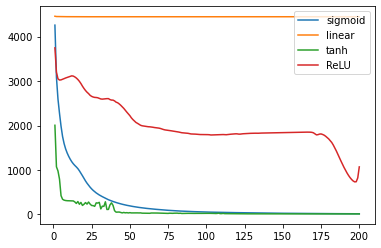

In [19]:
import matplotlib.pyplot as plt

x = list(range(1, 201))

plt.plot(x, err1, label='sigmoid')
plt.plot(x, err2, label='linear')
plt.plot(x, err3, label='tanh')
plt.plot(x, err4, label='ReLU')

plt.legend(loc='upper right')
plt.show()

In [20]:
print(f'sigmoid_mse: {mse1}\nlinear_mse:{mse2}\ntang_mse: {mse3}\nReLU_mse: {mse4}\n')

sigmoid_mse: 10.576425367341898
linear_mse:4434.41192236067
tang_mse: 8.356441178962935
ReLU_mse: 1302.5940985713187



## Dwie warstwy ukryte

### SIGMOID

In [21]:
np.random.seed(15)
net = Network()
net.add(Layer(1, 20))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(20, 30))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(30, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.00013, batch_size=10)

epoch 1/200   error=5196.084204
epoch 2/200   error=3877.381301
epoch 3/200   error=2276.598349
epoch 4/200   error=1661.557153
epoch 5/200   error=1527.944792
epoch 6/200   error=1509.051592
epoch 7/200   error=1475.174239
epoch 8/200   error=1413.083405
epoch 9/200   error=1380.089163
epoch 10/200   error=1365.032606
epoch 11/200   error=1358.374413
epoch 12/200   error=1354.920984
epoch 13/200   error=1350.617864
epoch 14/200   error=1287.774669
epoch 15/200   error=1033.315044
epoch 16/200   error=863.890694
epoch 17/200   error=755.977981
epoch 18/200   error=662.567363
epoch 19/200   error=590.613374
epoch 20/200   error=538.179289
epoch 21/200   error=501.216352
epoch 22/200   error=474.087561
epoch 23/200   error=454.815516
epoch 24/200   error=433.738317
epoch 25/200   error=423.929668
epoch 26/200   error=375.219525
epoch 27/200   error=355.026761
epoch 28/200   error=345.791282
epoch 29/200   error=350.210034
epoch 30/200   error=343.022855
epoch 31/200   error=328.668268
ep

In [22]:
err1 = net.errors
out = net.predict(x_test)
mse1 = mse(out, y_test)
print(mse1)

48.708464848764294


### LINIOWA

In [23]:
np.random.seed(45)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(linear, derivative_linear))
net.add(Layer(100, 50))
net.add(ActivationLayer(linear, derivative_linear))
net.add(Layer(50, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.00000001, batch_size=50)

epoch 1/200   error=30260.630467
epoch 2/200   error=4537.127594
epoch 3/200   error=4531.110023
epoch 4/200   error=4525.342630
epoch 5/200   error=4519.814375
epoch 6/200   error=4514.514732
epoch 7/200   error=4509.433847
epoch 8/200   error=4504.562469
epoch 9/200   error=4499.891894
epoch 10/200   error=4495.413916
epoch 11/200   error=4491.120782
epoch 12/200   error=4487.005152
epoch 13/200   error=4483.060058
epoch 14/200   error=4479.278879
epoch 15/200   error=4475.655309
epoch 16/200   error=4472.183329
epoch 17/200   error=4468.857188
epoch 18/200   error=4465.671379
epoch 19/200   error=4462.620624
epoch 20/200   error=4459.699854
epoch 21/200   error=4456.904199
epoch 22/200   error=4454.228970
epoch 23/200   error=4451.669649
epoch 24/200   error=4449.221882
epoch 25/200   error=4446.881466
epoch 26/200   error=4444.644339
epoch 27/200   error=4442.506580
epoch 28/200   error=4440.464395
epoch 29/200   error=4438.514115
epoch 30/200   error=4436.652189
epoch 31/200   err

In [24]:
err2 = net.errors
out = net.predict(x_test)
mse2 = mse(out, y_test)
print(mse2)

4434.094282666727


### TANH

In [25]:
np.random.seed(42)
net = Network()
net.add(Layer(1, 10))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(10, 40))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(40, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.0000999, batch_size=50)

epoch 1/200   error=4814.639549
epoch 2/200   error=4356.948513
epoch 3/200   error=4242.188883
epoch 4/200   error=4163.183509
epoch 5/200   error=4108.546792
epoch 6/200   error=4099.052154
epoch 7/200   error=4023.038609
epoch 8/200   error=3986.277473
epoch 9/200   error=3981.003185
epoch 10/200   error=3972.353752
epoch 11/200   error=3960.538174
epoch 12/200   error=3949.122817
epoch 13/200   error=3941.080112
epoch 14/200   error=3937.674317
epoch 15/200   error=3938.961227
epoch 16/200   error=3940.529057
epoch 17/200   error=3936.126235
epoch 18/200   error=3933.001116
epoch 19/200   error=3941.600905
epoch 20/200   error=3936.991014
epoch 21/200   error=3946.635953
epoch 22/200   error=3943.548459
epoch 23/200   error=3946.541247
epoch 24/200   error=3934.121544
epoch 25/200   error=3933.973104
epoch 26/200   error=3931.762083
epoch 27/200   error=3944.379948
epoch 28/200   error=3930.573163
epoch 29/200   error=3934.849691
epoch 30/200   error=3930.908592
epoch 31/200   erro

In [26]:
err3 = net.errors
out = net.predict(x_test)
mse3 = mse(out, y_test)
print(mse3)

390.5641310708132


### RELU

In [27]:
np.random.seed(10)
net = Network()
net.add(Layer(1, 20))
net.add(ActivationLayer(relu, derivative_relu))
net.add(Layer(20, 10))
net.add(ActivationLayer(relu, derivative_relu))
net.add(Layer(10, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.00001, batch_size=5)

epoch 1/200   error=3485.445015
epoch 2/200   error=3183.373285
epoch 3/200   error=2947.570300
epoch 4/200   error=2894.756330
epoch 5/200   error=2879.708686
epoch 6/200   error=2864.290319
epoch 7/200   error=2848.250994
epoch 8/200   error=2830.905847
epoch 9/200   error=2812.160985
epoch 10/200   error=2791.629595
epoch 11/200   error=2769.857275
epoch 12/200   error=2747.090200
epoch 13/200   error=2724.140353
epoch 14/200   error=2360.907959
epoch 15/200   error=1340.077951
epoch 16/200   error=980.244228
epoch 17/200   error=867.020838
epoch 18/200   error=827.682624
epoch 19/200   error=808.517352
epoch 20/200   error=796.250406
epoch 21/200   error=786.924604
epoch 22/200   error=779.110091
epoch 23/200   error=771.167090
epoch 24/200   error=764.345784
epoch 25/200   error=758.162775
epoch 26/200   error=752.302444
epoch 27/200   error=746.870417
epoch 28/200   error=741.582832
epoch 29/200   error=736.619218
epoch 30/200   error=731.632667
epoch 31/200   error=726.728620
ep

In [28]:
err4 = net.errors
out = net.predict(x_test)
mse4 = mse(out, y_test)
print(mse4)

147.49481316152693


## Porównanie

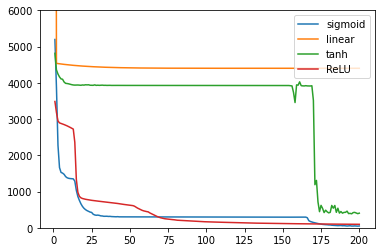

In [29]:
x = list(range(1, 201))

plt.plot(x, err1, label='sigmoid')
plt.plot(x, err2, label='linear')
plt.plot(x, err3, label='tanh')
plt.plot(x, err4, label='ReLU')

plt.legend(loc='upper right')
plt.ylim([0, 6000])
plt.show()

In [30]:
print(f'sigmoid_mse: {mse1}\nlinear_mse:{mse2}\ntang_mse: {mse3}\nReLU_mse: {mse4}\n')

sigmoid_mse: 48.708464848764294
linear_mse:4434.094282666727
tang_mse: 390.5641310708132
ReLU_mse: 147.49481316152693



## Trzy warstwy ukryte

### SIGMOID

In [31]:
np.random.seed(10)
net = Network()
net.add(Layer(1, 20))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(20, 20))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(20, 30))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(30, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.0007, batch_size=10)

epoch 1/200   error=5311.497779
epoch 2/200   error=5306.752358
epoch 3/200   error=5305.795339
epoch 4/200   error=5300.483686
epoch 5/200   error=5291.058733
epoch 6/200   error=5290.026590
epoch 7/200   error=5285.486349
epoch 8/200   error=5283.839257
epoch 9/200   error=5275.196277
epoch 10/200   error=5268.938753
epoch 11/200   error=5261.259364
epoch 12/200   error=5260.829455
epoch 13/200   error=5260.827236
epoch 14/200   error=5260.825708
epoch 15/200   error=5260.824169
epoch 16/200   error=5260.821932
epoch 17/200   error=5260.815245
epoch 18/200   error=5258.109960
epoch 19/200   error=5256.227420
epoch 20/200   error=5256.225574
epoch 21/200   error=5256.224336
epoch 22/200   error=5256.223013
epoch 23/200   error=5256.221250
epoch 24/200   error=5256.218191
epoch 25/200   error=5256.204688
epoch 26/200   error=5252.319575
epoch 27/200   error=5251.686733
epoch 28/200   error=5251.492442
epoch 29/200   error=5244.501430
epoch 30/200   error=5242.833421
epoch 31/200   erro

In [32]:
err1 = net.errors
out = net.predict(x_test)
mse1 = mse(out, y_test)
print(mse1)

1311.9813197796936


### LINIOWA

In [33]:
np.random.seed(10)
net = Network()
net.add(Layer(1, 10))
net.add(ActivationLayer(linear, derivative_linear))
net.add(Layer(10, 10))
net.add(ActivationLayer(linear, derivative_linear))
net.add(Layer(10, 10))
net.add(ActivationLayer(linear, derivative_linear))
net.add(Layer(10, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.00001, batch_size=50)

epoch 1/200   error=4511.241479
epoch 2/200   error=4455.933069
epoch 3/200   error=4452.095969
epoch 4/200   error=4450.353792
epoch 5/200   error=4449.281512
epoch 6/200   error=4448.458843
epoch 7/200   error=4447.756553
epoch 8/200   error=4447.132820
epoch 9/200   error=4446.572370
epoch 10/200   error=4446.068190
epoch 11/200   error=4445.615800
epoch 12/200   error=4445.211424
epoch 13/200   error=4444.851432
epoch 14/200   error=4444.532206
epoch 15/200   error=4444.250149
epoch 16/200   error=4444.001741
epoch 17/200   error=4443.783592
epoch 18/200   error=4443.592495
epoch 19/200   error=4443.425456
epoch 20/200   error=4443.279725
epoch 21/200   error=4443.152796
epoch 22/200   error=4443.042413
epoch 23/200   error=4442.946562
epoch 24/200   error=4442.863450
epoch 25/200   error=4442.791496
epoch 26/200   error=4442.729309
epoch 27/200   error=4442.675667
epoch 28/200   error=4442.629500
epoch 29/200   error=4442.589875
epoch 30/200   error=4442.555973
epoch 31/200   erro

In [34]:
err2 = net.errors
out = net.predict(x_test)
mse2 = mse(out, y_test)
print(mse2)

4434.160890340373


### TANH

In [35]:
np.random.seed(10)
net = Network()
net.add(Layer(1, 5))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(5, 10))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(10, 50))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(50, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.00005, batch_size=50)

epoch 1/200   error=3167.130252
epoch 2/200   error=2246.739302
epoch 3/200   error=1662.103161
epoch 4/200   error=1522.405225
epoch 5/200   error=1512.705734
epoch 6/200   error=1513.728709
epoch 7/200   error=1509.627848
epoch 8/200   error=1508.150403
epoch 9/200   error=1509.042990
epoch 10/200   error=1508.042866
epoch 11/200   error=1507.292410
epoch 12/200   error=1507.278565
epoch 13/200   error=1507.326979
epoch 14/200   error=1508.385918
epoch 15/200   error=1507.121890
epoch 16/200   error=1507.240441
epoch 17/200   error=1507.224548
epoch 18/200   error=1507.161789
epoch 19/200   error=1507.070128
epoch 20/200   error=1506.970615
epoch 21/200   error=1506.891293
epoch 22/200   error=1506.848668
epoch 23/200   error=1506.811893
epoch 24/200   error=1506.778227
epoch 25/200   error=1506.756699
epoch 26/200   error=1506.742493
epoch 27/200   error=1506.728545
epoch 28/200   error=1506.713733
epoch 29/200   error=1506.698947
epoch 30/200   error=1506.684763
epoch 31/200   erro

In [36]:
err3 = net.errors
out = net.predict(x_test)
mse3 = mse(out, y_test)
print(mse3)

1536.303435454404


### RELU

In [37]:
np.random.seed(10)
net = Network()
net.add(Layer(1, 32))
net.add(ActivationLayer(relu, derivative_relu))
net.add(Layer(32, 16))
net.add(ActivationLayer(relu, derivative_relu))
net.add(Layer(16, 8))
net.add(ActivationLayer(relu, derivative_relu))
net.add(Layer(8, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=200, learning_rate=0.000001, batch_size=5)

epoch 1/200   error=4406.857544
epoch 2/200   error=3558.878886
epoch 3/200   error=2996.182986
epoch 4/200   error=2719.824449
epoch 5/200   error=2549.913060
epoch 6/200   error=2451.808925
epoch 7/200   error=2366.927704
epoch 8/200   error=2273.080318
epoch 9/200   error=2132.624205
epoch 10/200   error=1893.817428
epoch 11/200   error=1535.808105
epoch 12/200   error=1177.662763
epoch 13/200   error=896.206429
epoch 14/200   error=796.611411
epoch 15/200   error=764.643765
epoch 16/200   error=732.480505
epoch 17/200   error=700.930129
epoch 18/200   error=674.672830
epoch 19/200   error=649.804712
epoch 20/200   error=626.239573
epoch 21/200   error=605.173482
epoch 22/200   error=586.760319
epoch 23/200   error=571.672542
epoch 24/200   error=560.348523
epoch 25/200   error=551.280625
epoch 26/200   error=544.475859
epoch 27/200   error=539.494185
epoch 28/200   error=535.983903
epoch 29/200   error=533.276016
epoch 30/200   error=530.888343
epoch 31/200   error=528.918676
epoch

In [38]:
err4 = net.errors
out = net.predict(x_test)
mse4 = mse(out, y_test)
print(mse4)

159.5602315920561


## Porównanie

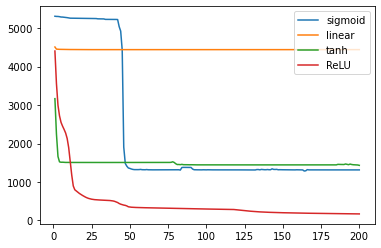

In [39]:
x = list(range(1, 201))

plt.plot(x, err1, label='sigmoid')
plt.plot(x, err2, label='linear')
plt.plot(x, err3, label='tanh')
plt.plot(x, err4, label='ReLU')

plt.legend(loc='upper right')
plt.show()

In [40]:
print(f'sigmoid_mse: {mse1}\nlinear_mse:{mse2}\ntang_mse: {mse3}\nReLU_mse: {mse4}\n')

sigmoid_mse: 1311.9813197796936
linear_mse:4434.160890340373
tang_mse: 1536.303435454404
ReLU_mse: 159.5602315920561



# steps-large

In [41]:
data = pd.read_csv('mio1/regression/steps-large-training.csv')
y_train = list(data.y)
y_train = np.array([[[y]] for y in y_train])
x_train = list(data.x)
x_train = np.array([[x] for x in x_train])

In [42]:
data = pd.read_csv('mio1/regression/steps-large-test.csv')
y_test = list(data.y)
y_test = np.array([[[y]] for y in y_test])
x_test = list(data.x)
x_test = np.array([[x] for x in x_test])

In [43]:
np.random.seed(20)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=100, learning_rate=0.0001, batch_size=50)

epoch 1/100   error=595.130757
epoch 2/100   error=463.907958
epoch 3/100   error=394.258785
epoch 4/100   error=313.806231
epoch 5/100   error=242.897088
epoch 6/100   error=195.089565
epoch 7/100   error=165.534369
epoch 8/100   error=147.112132
epoch 9/100   error=135.477277
epoch 10/100   error=128.146061
epoch 11/100   error=122.774919
epoch 12/100   error=118.448050
epoch 13/100   error=114.756640
epoch 14/100   error=111.493236
epoch 15/100   error=108.545441
epoch 16/100   error=105.846362
epoch 17/100   error=103.351759
epoch 18/100   error=101.029220
epoch 19/100   error=98.852158
epoch 20/100   error=96.797618
epoch 21/100   error=94.848913
epoch 22/100   error=92.995212
epoch 23/100   error=91.228693
epoch 24/100   error=89.546776
epoch 25/100   error=87.944534
epoch 26/100   error=86.414232
epoch 27/100   error=84.951247
epoch 28/100   error=83.552756
epoch 29/100   error=82.215139
epoch 30/100   error=80.934074
epoch 31/100   error=79.705495
epoch 32/100   error=78.526007

In [44]:
err1 = net.errors
out = net.predict(x_test)
mse1 = mse(out, y_test)
print(mse1)

46.17401195965741


In [45]:
np.random.seed(20)
net = Network()
net.add(Layer(1, 100))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(100, 1))
net.add(ActivationLayer(linear, derivative_linear))

net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=100, learning_rate=0.0001, batch_size=50)

epoch 1/100   error=1024.206549
epoch 2/100   error=499.542075
epoch 3/100   error=476.662324
epoch 4/100   error=464.279940
epoch 5/100   error=455.847289
epoch 6/100   error=449.128942
epoch 7/100   error=442.862368
epoch 8/100   error=436.254930
epoch 9/100   error=428.860066
epoch 10/100   error=420.479561
epoch 11/100   error=411.053685
epoch 12/100   error=400.527705
epoch 13/100   error=388.747812
epoch 14/100   error=375.481399
epoch 15/100   error=360.542935
epoch 16/100   error=343.915483
epoch 17/100   error=325.848299
epoch 18/100   error=306.850776
epoch 19/100   error=287.565758
epoch 20/100   error=268.628385
epoch 21/100   error=250.534093
epoch 22/100   error=233.580841
epoch 23/100   error=217.943438
epoch 24/100   error=203.730656
epoch 25/100   error=191.001064
epoch 26/100   error=179.767409
epoch 27/100   error=169.991168
epoch 28/100   error=161.566679
epoch 29/100   error=154.327568
epoch 30/100   error=148.087045
epoch 31/100   error=142.678140
epoch 32/100   e

In [46]:
err2 = net.errors
out = net.predict(x_test)
mse2 = mse(out, y_test)
print(mse2)

75.85823279301208


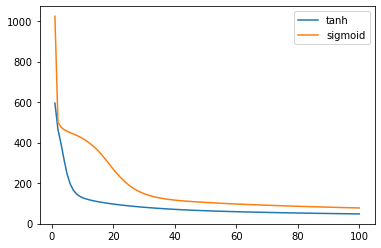

In [47]:
x = list(range(1, 101))

plt.plot(x, err1, label='tanh')
plt.plot(x, err2, label='sigmoid')

plt.legend(loc='upper right')
plt.show()

# rings3-regular

In [48]:
data = pd.read_csv('mio1/classification/rings3-regular-training.csv')
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

x_train = data[['x', 'y']].values.tolist()
x_train = np.array([[x] for x in x_train])
y_train = list(data.c)
y_train = np.array([[[y]] for y in y_train])

data = pd.read_csv('mio1/classification/rings3-regular-test.csv')
x_test = data[['x', 'y']].values.tolist()
x_test = np.array([[x] for x in x_test])
y_test = list(data.c)

In [49]:
np.random.seed(15)
net = Network()
net.add(Layer(2, 20))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(20, 30))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(30, 3))
net.add(ActivationLayer(softmax, derivative_softmax))

net.use(cost_function, cost_function_prime)
net.fit(x_train, y_train, epochs=3000, learning_rate=0.00013, batch_size=10)

epoch 1/3000   error=0.436422
epoch 2/3000   error=0.372190
epoch 3/3000   error=0.364428
epoch 4/3000   error=0.363896
epoch 5/3000   error=0.363807
epoch 6/3000   error=0.363731
epoch 7/3000   error=0.363653
epoch 8/3000   error=0.363575
epoch 9/3000   error=0.363497
epoch 10/3000   error=0.363421
epoch 11/3000   error=0.363345
epoch 12/3000   error=0.363271
epoch 13/3000   error=0.363199
epoch 14/3000   error=0.363128
epoch 15/3000   error=0.363058
epoch 16/3000   error=0.362989
epoch 17/3000   error=0.362922
epoch 18/3000   error=0.362856
epoch 19/3000   error=0.362791
epoch 20/3000   error=0.362727
epoch 21/3000   error=0.362664
epoch 22/3000   error=0.362602
epoch 23/3000   error=0.362541
epoch 24/3000   error=0.362480
epoch 25/3000   error=0.362420
epoch 26/3000   error=0.362360
epoch 27/3000   error=0.362301
epoch 28/3000   error=0.362243
epoch 29/3000   error=0.362184
epoch 30/3000   error=0.362126
epoch 31/3000   error=0.362069
epoch 32/3000   error=0.362011
epoch 33/3000   e

epoch 261/3000   error=0.352444
epoch 262/3000   error=0.352410
epoch 263/3000   error=0.352375
epoch 264/3000   error=0.352342
epoch 265/3000   error=0.352309
epoch 266/3000   error=0.352277
epoch 267/3000   error=0.352247
epoch 268/3000   error=0.352217
epoch 269/3000   error=0.352189
epoch 270/3000   error=0.352161
epoch 271/3000   error=0.352135
epoch 272/3000   error=0.352109
epoch 273/3000   error=0.352083
epoch 274/3000   error=0.352059
epoch 275/3000   error=0.352035
epoch 276/3000   error=0.352011
epoch 277/3000   error=0.351988
epoch 278/3000   error=0.351964
epoch 279/3000   error=0.351941
epoch 280/3000   error=0.351919
epoch 281/3000   error=0.351896
epoch 282/3000   error=0.351874
epoch 283/3000   error=0.351852
epoch 284/3000   error=0.351830
epoch 285/3000   error=0.351808
epoch 286/3000   error=0.351786
epoch 287/3000   error=0.351764
epoch 288/3000   error=0.351742
epoch 289/3000   error=0.351721
epoch 290/3000   error=0.351699
epoch 291/3000   error=0.351678
epoch 29

epoch 518/3000   error=0.347886
epoch 519/3000   error=0.347872
epoch 520/3000   error=0.347857
epoch 521/3000   error=0.347843
epoch 522/3000   error=0.347829
epoch 523/3000   error=0.347815
epoch 524/3000   error=0.347801
epoch 525/3000   error=0.347786
epoch 526/3000   error=0.347772
epoch 527/3000   error=0.347758
epoch 528/3000   error=0.347744
epoch 529/3000   error=0.347730
epoch 530/3000   error=0.347716
epoch 531/3000   error=0.347702
epoch 532/3000   error=0.347687
epoch 533/3000   error=0.347673
epoch 534/3000   error=0.347659
epoch 535/3000   error=0.347645
epoch 536/3000   error=0.347631
epoch 537/3000   error=0.347617
epoch 538/3000   error=0.347603
epoch 539/3000   error=0.347589
epoch 540/3000   error=0.347575
epoch 541/3000   error=0.347560
epoch 542/3000   error=0.347546
epoch 543/3000   error=0.347532
epoch 544/3000   error=0.347518
epoch 545/3000   error=0.347504
epoch 546/3000   error=0.347490
epoch 547/3000   error=0.347476
epoch 548/3000   error=0.347462
epoch 54

epoch 775/3000   error=0.343293
epoch 776/3000   error=0.343268
epoch 777/3000   error=0.343243
epoch 778/3000   error=0.343218
epoch 779/3000   error=0.343192
epoch 780/3000   error=0.343167
epoch 781/3000   error=0.343141
epoch 782/3000   error=0.343116
epoch 783/3000   error=0.343090
epoch 784/3000   error=0.343063
epoch 785/3000   error=0.343037
epoch 786/3000   error=0.343011
epoch 787/3000   error=0.342984
epoch 788/3000   error=0.342957
epoch 789/3000   error=0.342930
epoch 790/3000   error=0.342903
epoch 791/3000   error=0.342875
epoch 792/3000   error=0.342848
epoch 793/3000   error=0.342820
epoch 794/3000   error=0.342791
epoch 795/3000   error=0.342763
epoch 796/3000   error=0.342734
epoch 797/3000   error=0.342705
epoch 798/3000   error=0.342676
epoch 799/3000   error=0.342646
epoch 800/3000   error=0.342616
epoch 801/3000   error=0.342585
epoch 802/3000   error=0.342554
epoch 803/3000   error=0.342522
epoch 804/3000   error=0.342490
epoch 805/3000   error=0.342458
epoch 80

epoch 1031/3000   error=0.334072
epoch 1032/3000   error=0.334027
epoch 1033/3000   error=0.333983
epoch 1034/3000   error=0.333938
epoch 1035/3000   error=0.333893
epoch 1036/3000   error=0.333849
epoch 1037/3000   error=0.333804
epoch 1038/3000   error=0.333760
epoch 1039/3000   error=0.333716
epoch 1040/3000   error=0.333672
epoch 1041/3000   error=0.333628
epoch 1042/3000   error=0.333584
epoch 1043/3000   error=0.333540
epoch 1044/3000   error=0.333497
epoch 1045/3000   error=0.333453
epoch 1046/3000   error=0.333409
epoch 1047/3000   error=0.333366
epoch 1048/3000   error=0.333323
epoch 1049/3000   error=0.333281
epoch 1050/3000   error=0.333239
epoch 1051/3000   error=0.333197
epoch 1052/3000   error=0.333156
epoch 1053/3000   error=0.333116
epoch 1054/3000   error=0.333075
epoch 1055/3000   error=0.333035
epoch 1056/3000   error=0.332995
epoch 1057/3000   error=0.332955
epoch 1058/3000   error=0.332915
epoch 1059/3000   error=0.332875
epoch 1060/3000   error=0.332835
epoch 1061

epoch 1280/3000   error=0.320781
epoch 1281/3000   error=0.320731
epoch 1282/3000   error=0.320681
epoch 1283/3000   error=0.320631
epoch 1284/3000   error=0.320582
epoch 1285/3000   error=0.320532
epoch 1286/3000   error=0.320483
epoch 1287/3000   error=0.320434
epoch 1288/3000   error=0.320384
epoch 1289/3000   error=0.320335
epoch 1290/3000   error=0.320286
epoch 1291/3000   error=0.320237
epoch 1292/3000   error=0.320188
epoch 1293/3000   error=0.320139
epoch 1294/3000   error=0.320091
epoch 1295/3000   error=0.320042
epoch 1296/3000   error=0.319993
epoch 1297/3000   error=0.319944
epoch 1298/3000   error=0.319896
epoch 1299/3000   error=0.319847
epoch 1300/3000   error=0.319798
epoch 1301/3000   error=0.319749
epoch 1302/3000   error=0.319701
epoch 1303/3000   error=0.319652
epoch 1304/3000   error=0.319603
epoch 1305/3000   error=0.319555
epoch 1306/3000   error=0.319506
epoch 1307/3000   error=0.319458
epoch 1308/3000   error=0.319409
epoch 1309/3000   error=0.319360
epoch 1310

epoch 1529/3000   error=0.308536
epoch 1530/3000   error=0.308487
epoch 1531/3000   error=0.308438
epoch 1532/3000   error=0.308389
epoch 1533/3000   error=0.308340
epoch 1534/3000   error=0.308291
epoch 1535/3000   error=0.308242
epoch 1536/3000   error=0.308193
epoch 1537/3000   error=0.308144
epoch 1538/3000   error=0.308095
epoch 1539/3000   error=0.308047
epoch 1540/3000   error=0.307998
epoch 1541/3000   error=0.307949
epoch 1542/3000   error=0.307901
epoch 1543/3000   error=0.307852
epoch 1544/3000   error=0.307804
epoch 1545/3000   error=0.307755
epoch 1546/3000   error=0.307707
epoch 1547/3000   error=0.307658
epoch 1548/3000   error=0.307610
epoch 1549/3000   error=0.307562
epoch 1550/3000   error=0.307513
epoch 1551/3000   error=0.307465
epoch 1552/3000   error=0.307417
epoch 1553/3000   error=0.307369
epoch 1554/3000   error=0.307321
epoch 1555/3000   error=0.307272
epoch 1556/3000   error=0.307224
epoch 1557/3000   error=0.307176
epoch 1558/3000   error=0.307128
epoch 1559

epoch 1778/3000   error=0.295196
epoch 1779/3000   error=0.295145
epoch 1780/3000   error=0.295094
epoch 1781/3000   error=0.295043
epoch 1782/3000   error=0.294992
epoch 1783/3000   error=0.294941
epoch 1784/3000   error=0.294891
epoch 1785/3000   error=0.294840
epoch 1786/3000   error=0.294789
epoch 1787/3000   error=0.294739
epoch 1788/3000   error=0.294688
epoch 1789/3000   error=0.294637
epoch 1790/3000   error=0.294587
epoch 1791/3000   error=0.294536
epoch 1792/3000   error=0.294486
epoch 1793/3000   error=0.294436
epoch 1794/3000   error=0.294386
epoch 1795/3000   error=0.294336
epoch 1796/3000   error=0.294286
epoch 1797/3000   error=0.294236
epoch 1798/3000   error=0.294186
epoch 1799/3000   error=0.294136
epoch 1800/3000   error=0.294086
epoch 1801/3000   error=0.294036
epoch 1802/3000   error=0.293987
epoch 1803/3000   error=0.293937
epoch 1804/3000   error=0.293888
epoch 1805/3000   error=0.293838
epoch 1806/3000   error=0.293789
epoch 1807/3000   error=0.293740
epoch 1808

epoch 2027/3000   error=0.284871
epoch 2028/3000   error=0.284842
epoch 2029/3000   error=0.284813
epoch 2030/3000   error=0.284784
epoch 2031/3000   error=0.284755
epoch 2032/3000   error=0.284727
epoch 2033/3000   error=0.284698
epoch 2034/3000   error=0.284670
epoch 2035/3000   error=0.284641
epoch 2036/3000   error=0.284613
epoch 2037/3000   error=0.284585
epoch 2038/3000   error=0.284557
epoch 2039/3000   error=0.284529
epoch 2040/3000   error=0.284501
epoch 2041/3000   error=0.284473
epoch 2042/3000   error=0.284445
epoch 2043/3000   error=0.284417
epoch 2044/3000   error=0.284390
epoch 2045/3000   error=0.284362
epoch 2046/3000   error=0.284335
epoch 2047/3000   error=0.284307
epoch 2048/3000   error=0.284280
epoch 2049/3000   error=0.284253
epoch 2050/3000   error=0.284226
epoch 2051/3000   error=0.284199
epoch 2052/3000   error=0.284172
epoch 2053/3000   error=0.284145
epoch 2054/3000   error=0.284119
epoch 2055/3000   error=0.284092
epoch 2056/3000   error=0.284066
epoch 2057

epoch 2276/3000   error=0.281445
epoch 2277/3000   error=0.281432
epoch 2278/3000   error=0.281419
epoch 2279/3000   error=0.281405
epoch 2280/3000   error=0.281392
epoch 2281/3000   error=0.281379
epoch 2282/3000   error=0.281367
epoch 2283/3000   error=0.281354
epoch 2284/3000   error=0.281341
epoch 2285/3000   error=0.281329
epoch 2286/3000   error=0.281317
epoch 2287/3000   error=0.281305
epoch 2288/3000   error=0.281293
epoch 2289/3000   error=0.281281
epoch 2290/3000   error=0.281270
epoch 2291/3000   error=0.281259
epoch 2292/3000   error=0.281247
epoch 2293/3000   error=0.281236
epoch 2294/3000   error=0.281226
epoch 2295/3000   error=0.281215
epoch 2296/3000   error=0.281204
epoch 2297/3000   error=0.281194
epoch 2298/3000   error=0.281184
epoch 2299/3000   error=0.281174
epoch 2300/3000   error=0.281165
epoch 2301/3000   error=0.281155
epoch 2302/3000   error=0.281146
epoch 2303/3000   error=0.281138
epoch 2304/3000   error=0.281129
epoch 2305/3000   error=0.281121
epoch 2306

epoch 2525/3000   error=0.279724
epoch 2526/3000   error=0.279718
epoch 2527/3000   error=0.279712
epoch 2528/3000   error=0.279706
epoch 2529/3000   error=0.279701
epoch 2530/3000   error=0.279695
epoch 2531/3000   error=0.279689
epoch 2532/3000   error=0.279684
epoch 2533/3000   error=0.279679
epoch 2534/3000   error=0.279674
epoch 2535/3000   error=0.279669
epoch 2536/3000   error=0.279664
epoch 2537/3000   error=0.279659
epoch 2538/3000   error=0.279654
epoch 2539/3000   error=0.279649
epoch 2540/3000   error=0.279645
epoch 2541/3000   error=0.279641
epoch 2542/3000   error=0.279636
epoch 2543/3000   error=0.279632
epoch 2544/3000   error=0.279628
epoch 2545/3000   error=0.279624
epoch 2546/3000   error=0.279620
epoch 2547/3000   error=0.279617
epoch 2548/3000   error=0.279613
epoch 2549/3000   error=0.279610
epoch 2550/3000   error=0.279606
epoch 2551/3000   error=0.279603
epoch 2552/3000   error=0.279600
epoch 2553/3000   error=0.279597
epoch 2554/3000   error=0.279595
epoch 2555

epoch 2774/3000   error=0.281775
epoch 2775/3000   error=0.281756
epoch 2776/3000   error=0.281738
epoch 2777/3000   error=0.281719
epoch 2778/3000   error=0.281701
epoch 2779/3000   error=0.281682
epoch 2780/3000   error=0.281664
epoch 2781/3000   error=0.281645
epoch 2782/3000   error=0.281627
epoch 2783/3000   error=0.281610
epoch 2784/3000   error=0.281592
epoch 2785/3000   error=0.281576
epoch 2786/3000   error=0.281559
epoch 2787/3000   error=0.281544
epoch 2788/3000   error=0.281528
epoch 2789/3000   error=0.281514
epoch 2790/3000   error=0.281500
epoch 2791/3000   error=0.281487
epoch 2792/3000   error=0.281475
epoch 2793/3000   error=0.281464
epoch 2794/3000   error=0.281453
epoch 2795/3000   error=0.281443
epoch 2796/3000   error=0.281433
epoch 2797/3000   error=0.281424
epoch 2798/3000   error=0.281416
epoch 2799/3000   error=0.281407
epoch 2800/3000   error=0.281400
epoch 2801/3000   error=0.281393
epoch 2802/3000   error=0.281386
epoch 2803/3000   error=0.281379
epoch 2804

In [50]:
err_sigmoid = net.errors
out = net.predict(x_test)
out = [np.argmax(l) for l in out]
f1_score(y_test, out, average = 'weighted')

0.675299907945957

In [51]:
np.random.seed(52)
net = Network()
net.add(Layer(2, 50))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(50, 10))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(10, 3))
net.add(ActivationLayer(softmax, derivative_softmax))

net.use(cost_function, cost_function_prime)
net.fit(x_train, y_train, epochs=3000, learning_rate=0.00006, batch_size=250)

epoch 1/3000   error=0.686041
epoch 2/3000   error=0.612678
epoch 3/3000   error=0.547245
epoch 4/3000   error=0.491952
epoch 5/3000   error=0.448471
epoch 6/3000   error=0.416977
epoch 7/3000   error=0.395819
epoch 8/3000   error=0.382402
epoch 9/3000   error=0.374168
epoch 10/3000   error=0.369182
epoch 11/3000   error=0.366165
epoch 12/3000   error=0.364315
epoch 13/3000   error=0.363146
epoch 14/3000   error=0.362375
epoch 15/3000   error=0.361842
epoch 16/3000   error=0.361451
epoch 17/3000   error=0.361147
epoch 18/3000   error=0.360895
epoch 19/3000   error=0.360677
epoch 20/3000   error=0.360479
epoch 21/3000   error=0.360296
epoch 22/3000   error=0.360123
epoch 23/3000   error=0.359964
epoch 24/3000   error=0.359797
epoch 25/3000   error=0.359429
epoch 26/3000   error=0.359212
epoch 27/3000   error=0.359047
epoch 28/3000   error=0.358904
epoch 29/3000   error=0.358789
epoch 30/3000   error=0.358686
epoch 31/3000   error=0.358532
epoch 32/3000   error=0.357969
epoch 33/3000   e

epoch 261/3000   error=0.352250
epoch 262/3000   error=0.352248
epoch 263/3000   error=0.352246
epoch 264/3000   error=0.352244
epoch 265/3000   error=0.352242
epoch 266/3000   error=0.352239
epoch 267/3000   error=0.352237
epoch 268/3000   error=0.352235
epoch 269/3000   error=0.352233
epoch 270/3000   error=0.352231
epoch 271/3000   error=0.352229
epoch 272/3000   error=0.352227
epoch 273/3000   error=0.352224
epoch 274/3000   error=0.352222
epoch 275/3000   error=0.352220
epoch 276/3000   error=0.352218
epoch 277/3000   error=0.352216
epoch 278/3000   error=0.352214
epoch 279/3000   error=0.352212
epoch 280/3000   error=0.352210
epoch 281/3000   error=0.352208
epoch 282/3000   error=0.352206
epoch 283/3000   error=0.352204
epoch 284/3000   error=0.352201
epoch 285/3000   error=0.352199
epoch 286/3000   error=0.352197
epoch 287/3000   error=0.352195
epoch 288/3000   error=0.352193
epoch 289/3000   error=0.352191
epoch 290/3000   error=0.352189
epoch 291/3000   error=0.352187
epoch 29

epoch 518/3000   error=0.351785
epoch 519/3000   error=0.351783
epoch 520/3000   error=0.351782
epoch 521/3000   error=0.351780
epoch 522/3000   error=0.351779
epoch 523/3000   error=0.351777
epoch 524/3000   error=0.351776
epoch 525/3000   error=0.351774
epoch 526/3000   error=0.351773
epoch 527/3000   error=0.351771
epoch 528/3000   error=0.351770
epoch 529/3000   error=0.351768
epoch 530/3000   error=0.351767
epoch 531/3000   error=0.351765
epoch 532/3000   error=0.351763
epoch 533/3000   error=0.351762
epoch 534/3000   error=0.351760
epoch 535/3000   error=0.351759
epoch 536/3000   error=0.351757
epoch 537/3000   error=0.351756
epoch 538/3000   error=0.351754
epoch 539/3000   error=0.351753
epoch 540/3000   error=0.351751
epoch 541/3000   error=0.351750
epoch 542/3000   error=0.351748
epoch 543/3000   error=0.351747
epoch 544/3000   error=0.351745
epoch 545/3000   error=0.351744
epoch 546/3000   error=0.351742
epoch 547/3000   error=0.351741
epoch 548/3000   error=0.351739
epoch 54

epoch 775/3000   error=0.351430
epoch 776/3000   error=0.351429
epoch 777/3000   error=0.351427
epoch 778/3000   error=0.351426
epoch 779/3000   error=0.351425
epoch 780/3000   error=0.351424
epoch 781/3000   error=0.351423
epoch 782/3000   error=0.351421
epoch 783/3000   error=0.351420
epoch 784/3000   error=0.351419
epoch 785/3000   error=0.351418
epoch 786/3000   error=0.351417
epoch 787/3000   error=0.351415
epoch 788/3000   error=0.351414
epoch 789/3000   error=0.351413
epoch 790/3000   error=0.351412
epoch 791/3000   error=0.351411
epoch 792/3000   error=0.351409
epoch 793/3000   error=0.351408
epoch 794/3000   error=0.351407
epoch 795/3000   error=0.351406
epoch 796/3000   error=0.351405
epoch 797/3000   error=0.351403
epoch 798/3000   error=0.351402
epoch 799/3000   error=0.351401
epoch 800/3000   error=0.351400
epoch 801/3000   error=0.351399
epoch 802/3000   error=0.351398
epoch 803/3000   error=0.351396
epoch 804/3000   error=0.351395
epoch 805/3000   error=0.351394
epoch 80

epoch 1031/3000   error=0.350973
epoch 1032/3000   error=0.350968
epoch 1033/3000   error=0.350962
epoch 1034/3000   error=0.350956
epoch 1035/3000   error=0.350950
epoch 1036/3000   error=0.350945
epoch 1037/3000   error=0.350939
epoch 1038/3000   error=0.350933
epoch 1039/3000   error=0.350927
epoch 1040/3000   error=0.350921
epoch 1041/3000   error=0.350915
epoch 1042/3000   error=0.350909
epoch 1043/3000   error=0.350903
epoch 1044/3000   error=0.350898
epoch 1045/3000   error=0.350892
epoch 1046/3000   error=0.350886
epoch 1047/3000   error=0.350880
epoch 1048/3000   error=0.350874
epoch 1049/3000   error=0.350868
epoch 1050/3000   error=0.350862
epoch 1051/3000   error=0.350856
epoch 1052/3000   error=0.350850
epoch 1053/3000   error=0.350845
epoch 1054/3000   error=0.350839
epoch 1055/3000   error=0.350833
epoch 1056/3000   error=0.350828
epoch 1057/3000   error=0.350822
epoch 1058/3000   error=0.350817
epoch 1059/3000   error=0.350811
epoch 1060/3000   error=0.350806
epoch 1061

epoch 1280/3000   error=0.349821
epoch 1281/3000   error=0.349817
epoch 1282/3000   error=0.349812
epoch 1283/3000   error=0.349808
epoch 1284/3000   error=0.349804
epoch 1285/3000   error=0.349799
epoch 1286/3000   error=0.349795
epoch 1287/3000   error=0.349791
epoch 1288/3000   error=0.349787
epoch 1289/3000   error=0.349782
epoch 1290/3000   error=0.349778
epoch 1291/3000   error=0.349774
epoch 1292/3000   error=0.349769
epoch 1293/3000   error=0.349765
epoch 1294/3000   error=0.349761
epoch 1295/3000   error=0.349757
epoch 1296/3000   error=0.349752
epoch 1297/3000   error=0.349748
epoch 1298/3000   error=0.349744
epoch 1299/3000   error=0.349740
epoch 1300/3000   error=0.349735
epoch 1301/3000   error=0.349731
epoch 1302/3000   error=0.349727
epoch 1303/3000   error=0.349723
epoch 1304/3000   error=0.349718
epoch 1305/3000   error=0.349714
epoch 1306/3000   error=0.349710
epoch 1307/3000   error=0.349706
epoch 1308/3000   error=0.349701
epoch 1309/3000   error=0.349697
epoch 1310

epoch 1529/3000   error=0.348815
epoch 1530/3000   error=0.348811
epoch 1531/3000   error=0.348807
epoch 1532/3000   error=0.348803
epoch 1533/3000   error=0.348799
epoch 1534/3000   error=0.348796
epoch 1535/3000   error=0.348792
epoch 1536/3000   error=0.348788
epoch 1537/3000   error=0.348784
epoch 1538/3000   error=0.348780
epoch 1539/3000   error=0.348776
epoch 1540/3000   error=0.348772
epoch 1541/3000   error=0.348768
epoch 1542/3000   error=0.348764
epoch 1543/3000   error=0.348760
epoch 1544/3000   error=0.348756
epoch 1545/3000   error=0.348753
epoch 1546/3000   error=0.348749
epoch 1547/3000   error=0.348745
epoch 1548/3000   error=0.348741
epoch 1549/3000   error=0.348737
epoch 1550/3000   error=0.348733
epoch 1551/3000   error=0.348729
epoch 1552/3000   error=0.348725
epoch 1553/3000   error=0.348722
epoch 1554/3000   error=0.348717
epoch 1555/3000   error=0.348715
epoch 1556/3000   error=0.348708
epoch 1557/3000   error=0.348708
epoch 1558/3000   error=0.348698
epoch 1559

epoch 1778/3000   error=0.347697
epoch 1779/3000   error=0.347953
epoch 1780/3000   error=0.347690
epoch 1781/3000   error=0.347944
epoch 1782/3000   error=0.347683
epoch 1783/3000   error=0.347935
epoch 1784/3000   error=0.347677
epoch 1785/3000   error=0.347926
epoch 1786/3000   error=0.347670
epoch 1787/3000   error=0.347917
epoch 1788/3000   error=0.347663
epoch 1789/3000   error=0.347909
epoch 1790/3000   error=0.347656
epoch 1791/3000   error=0.347900
epoch 1792/3000   error=0.347649
epoch 1793/3000   error=0.347891
epoch 1794/3000   error=0.347643
epoch 1795/3000   error=0.347882
epoch 1796/3000   error=0.347636
epoch 1797/3000   error=0.347873
epoch 1798/3000   error=0.347630
epoch 1799/3000   error=0.347864
epoch 1800/3000   error=0.347623
epoch 1801/3000   error=0.347855
epoch 1802/3000   error=0.347617
epoch 1803/3000   error=0.347846
epoch 1804/3000   error=0.347610
epoch 1805/3000   error=0.347837
epoch 1806/3000   error=0.347604
epoch 1807/3000   error=0.347828
epoch 1808

epoch 2027/3000   error=0.346593
epoch 2028/3000   error=0.346650
epoch 2029/3000   error=0.347315
epoch 2030/3000   error=0.346583
epoch 2031/3000   error=0.346548
epoch 2032/3000   error=0.346563
epoch 2033/3000   error=0.346622
epoch 2034/3000   error=0.347282
epoch 2035/3000   error=0.346555
epoch 2036/3000   error=0.346520
epoch 2037/3000   error=0.346531
epoch 2038/3000   error=0.346571
epoch 2039/3000   error=0.347012
epoch 2040/3000   error=0.346460
epoch 2041/3000   error=0.346486
epoch 2042/3000   error=0.346510
epoch 2043/3000   error=0.346580
epoch 2044/3000   error=0.347330
epoch 2045/3000   error=0.346572
epoch 2046/3000   error=0.346459
epoch 2047/3000   error=0.346486
epoch 2048/3000   error=0.346595
epoch 2049/3000   error=0.347254
epoch 2050/3000   error=0.346435
epoch 2051/3000   error=0.346650
epoch 2052/3000   error=0.347177
epoch 2053/3000   error=0.346391
epoch 2054/3000   error=0.346411
epoch 2055/3000   error=0.346393
epoch 2056/3000   error=0.346404
epoch 2057

epoch 2276/3000   error=0.345619
epoch 2277/3000   error=0.345107
epoch 2278/3000   error=0.345606
epoch 2279/3000   error=0.345162
epoch 2280/3000   error=0.345641
epoch 2281/3000   error=0.345068
epoch 2282/3000   error=0.345595
epoch 2283/3000   error=0.345045
epoch 2284/3000   error=0.345575
epoch 2285/3000   error=0.345043
epoch 2286/3000   error=0.345562
epoch 2287/3000   error=0.345041
epoch 2288/3000   error=0.345551
epoch 2289/3000   error=0.345063
epoch 2290/3000   error=0.345534
epoch 2291/3000   error=0.345232
epoch 2292/3000   error=0.345600
epoch 2293/3000   error=0.345027
epoch 2294/3000   error=0.345548
epoch 2295/3000   error=0.345075
epoch 2296/3000   error=0.345546
epoch 2297/3000   error=0.345029
epoch 2298/3000   error=0.345497
epoch 2299/3000   error=0.345191
epoch 2300/3000   error=0.345567
epoch 2301/3000   error=0.345055
epoch 2302/3000   error=0.345492
epoch 2303/3000   error=0.345177
epoch 2304/3000   error=0.345531
epoch 2305/3000   error=0.344943
epoch 2306

epoch 2525/3000   error=0.343006
epoch 2526/3000   error=0.343146
epoch 2527/3000   error=0.344332
epoch 2528/3000   error=0.344271
epoch 2529/3000   error=0.343126
epoch 2530/3000   error=0.343419
epoch 2531/3000   error=0.343624
epoch 2532/3000   error=0.343575
epoch 2533/3000   error=0.343264
epoch 2534/3000   error=0.344166
epoch 2535/3000   error=0.344524
epoch 2536/3000   error=0.342907
epoch 2537/3000   error=0.343830
epoch 2538/3000   error=0.342906
epoch 2539/3000   error=0.344076
epoch 2540/3000   error=0.344204
epoch 2541/3000   error=0.343502
epoch 2542/3000   error=0.343018
epoch 2543/3000   error=0.344366
epoch 2544/3000   error=0.342997
epoch 2545/3000   error=0.344426
epoch 2546/3000   error=0.342817
epoch 2547/3000   error=0.344311
epoch 2548/3000   error=0.342978
epoch 2549/3000   error=0.344243
epoch 2550/3000   error=0.342977
epoch 2551/3000   error=0.344087
epoch 2552/3000   error=0.342947
epoch 2553/3000   error=0.344264
epoch 2554/3000   error=0.342640
epoch 2555

epoch 2774/3000   error=0.344542
epoch 2775/3000   error=0.343486
epoch 2776/3000   error=0.342467
epoch 2777/3000   error=0.341852
epoch 2778/3000   error=0.342275
epoch 2779/3000   error=0.342649
epoch 2780/3000   error=0.341856
epoch 2781/3000   error=0.342301
epoch 2782/3000   error=0.341751
epoch 2783/3000   error=0.342329
epoch 2784/3000   error=0.342507
epoch 2785/3000   error=0.342278
epoch 2786/3000   error=0.341297
epoch 2787/3000   error=0.341785
epoch 2788/3000   error=0.342933
epoch 2789/3000   error=0.342106
epoch 2790/3000   error=0.342180
epoch 2791/3000   error=0.343548
epoch 2792/3000   error=0.343277
epoch 2793/3000   error=0.342866
epoch 2794/3000   error=0.343476
epoch 2795/3000   error=0.342010
epoch 2796/3000   error=0.343487
epoch 2797/3000   error=0.342632
epoch 2798/3000   error=0.343048
epoch 2799/3000   error=0.343551
epoch 2800/3000   error=0.344202
epoch 2801/3000   error=0.345651
epoch 2802/3000   error=0.343877
epoch 2803/3000   error=0.343376
epoch 2804

In [52]:
err_tanh = net.errors
out = net.predict(x_test)
out = [np.argmax(l) for l in out]
f1_score(y_test, out, average = 'weighted')

0.5148769296346077

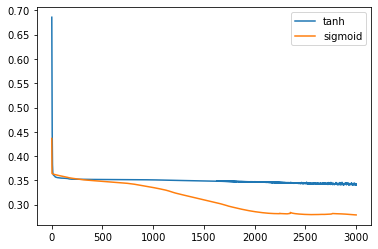

In [53]:
x = list(range(1, 3001))

plt.plot(x, err_tanh, label='tanh')
plt.plot(x, err_sigmoid, label='sigmoid')

plt.legend(loc='upper right')
plt.show()

# rings5-regular

In [54]:
data = pd.read_csv('mio1/classification/rings5-regular-training.csv')
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

x_train = data[['x', 'y']].values.tolist()
x_train = np.array([[x] for x in x_train])
y_train = list(data.c)
y_train = np.array([[[y]] for y in y_train])

data = pd.read_csv('mio1/classification/rings5-regular-test.csv')
x_test = data[['x', 'y']].values.tolist()
x_test = np.array([[x] for x in x_test])
y_test = list(data.c)

In [55]:
np.random.seed(15)
net = Network()
net.add(Layer(2, 20))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(20, 30))
net.add(ActivationLayer(sigmoid, derivative_sigmoid))
net.add(Layer(30, 5))
net.add(ActivationLayer(softmax, derivative_softmax))

net.use(cost_function, cost_function_prime)
net.fit(x_train, y_train, epochs=3000, learning_rate=0.00013, batch_size=10)

epoch 1/3000   error=0.423844
epoch 2/3000   error=0.345877
epoch 3/3000   error=0.327121
epoch 4/3000   error=0.323389
epoch 5/3000   error=0.322581
epoch 6/3000   error=0.322336
epoch 7/3000   error=0.322198
epoch 8/3000   error=0.322079
epoch 9/3000   error=0.321963
epoch 10/3000   error=0.321848
epoch 11/3000   error=0.321735
epoch 12/3000   error=0.321622
epoch 13/3000   error=0.321512
epoch 14/3000   error=0.321402
epoch 15/3000   error=0.321295
epoch 16/3000   error=0.321188
epoch 17/3000   error=0.321084
epoch 18/3000   error=0.320980
epoch 19/3000   error=0.320877
epoch 20/3000   error=0.320775
epoch 21/3000   error=0.320673
epoch 22/3000   error=0.320571
epoch 23/3000   error=0.320469
epoch 24/3000   error=0.320366
epoch 25/3000   error=0.320263
epoch 26/3000   error=0.320158
epoch 27/3000   error=0.320051
epoch 28/3000   error=0.319943
epoch 29/3000   error=0.319834
epoch 30/3000   error=0.319723
epoch 31/3000   error=0.319612
epoch 32/3000   error=0.319500
epoch 33/3000   e

epoch 261/3000   error=0.302219
epoch 262/3000   error=0.302151
epoch 263/3000   error=0.302083
epoch 264/3000   error=0.302015
epoch 265/3000   error=0.301947
epoch 266/3000   error=0.301880
epoch 267/3000   error=0.301812
epoch 268/3000   error=0.301744
epoch 269/3000   error=0.301677
epoch 270/3000   error=0.301610
epoch 271/3000   error=0.301543
epoch 272/3000   error=0.301475
epoch 273/3000   error=0.301409
epoch 274/3000   error=0.301342
epoch 275/3000   error=0.301275
epoch 276/3000   error=0.301209
epoch 277/3000   error=0.301142
epoch 278/3000   error=0.301076
epoch 279/3000   error=0.301010
epoch 280/3000   error=0.300944
epoch 281/3000   error=0.300878
epoch 282/3000   error=0.300813
epoch 283/3000   error=0.300747
epoch 284/3000   error=0.300682
epoch 285/3000   error=0.300617
epoch 286/3000   error=0.300552
epoch 287/3000   error=0.300487
epoch 288/3000   error=0.300422
epoch 289/3000   error=0.300358
epoch 290/3000   error=0.300294
epoch 291/3000   error=0.300229
epoch 29

epoch 518/3000   error=0.289246
epoch 519/3000   error=0.289212
epoch 520/3000   error=0.289178
epoch 521/3000   error=0.289144
epoch 522/3000   error=0.289110
epoch 523/3000   error=0.289076
epoch 524/3000   error=0.289042
epoch 525/3000   error=0.289008
epoch 526/3000   error=0.288974
epoch 527/3000   error=0.288941
epoch 528/3000   error=0.288907
epoch 529/3000   error=0.288873
epoch 530/3000   error=0.288840
epoch 531/3000   error=0.288807
epoch 532/3000   error=0.288774
epoch 533/3000   error=0.288741
epoch 534/3000   error=0.288708
epoch 535/3000   error=0.288675
epoch 536/3000   error=0.288642
epoch 537/3000   error=0.288610
epoch 538/3000   error=0.288578
epoch 539/3000   error=0.288546
epoch 540/3000   error=0.288514
epoch 541/3000   error=0.288482
epoch 542/3000   error=0.288450
epoch 543/3000   error=0.288418
epoch 544/3000   error=0.288387
epoch 545/3000   error=0.288355
epoch 546/3000   error=0.288324
epoch 547/3000   error=0.288293
epoch 548/3000   error=0.288262
epoch 54

epoch 775/3000   error=0.283055
epoch 776/3000   error=0.283036
epoch 777/3000   error=0.283018
epoch 778/3000   error=0.282999
epoch 779/3000   error=0.282981
epoch 780/3000   error=0.282962
epoch 781/3000   error=0.282944
epoch 782/3000   error=0.282925
epoch 783/3000   error=0.282907
epoch 784/3000   error=0.282888
epoch 785/3000   error=0.282870
epoch 786/3000   error=0.282852
epoch 787/3000   error=0.282833
epoch 788/3000   error=0.282815
epoch 789/3000   error=0.282797
epoch 790/3000   error=0.282778
epoch 791/3000   error=0.282760
epoch 792/3000   error=0.282742
epoch 793/3000   error=0.282724
epoch 794/3000   error=0.282705
epoch 795/3000   error=0.282687
epoch 796/3000   error=0.282669
epoch 797/3000   error=0.282651
epoch 798/3000   error=0.282632
epoch 799/3000   error=0.282614
epoch 800/3000   error=0.282596
epoch 801/3000   error=0.282578
epoch 802/3000   error=0.282560
epoch 803/3000   error=0.282542
epoch 804/3000   error=0.282523
epoch 805/3000   error=0.282505
epoch 80

epoch 1031/3000   error=0.276515
epoch 1032/3000   error=0.276442
epoch 1033/3000   error=0.276371
epoch 1034/3000   error=0.276305
epoch 1035/3000   error=0.276242
epoch 1036/3000   error=0.276184
epoch 1037/3000   error=0.276129
epoch 1038/3000   error=0.276077
epoch 1039/3000   error=0.276027
epoch 1040/3000   error=0.275979
epoch 1041/3000   error=0.275931
epoch 1042/3000   error=0.275884
epoch 1043/3000   error=0.275837
epoch 1044/3000   error=0.275790
epoch 1045/3000   error=0.275743
epoch 1046/3000   error=0.275695
epoch 1047/3000   error=0.275647
epoch 1048/3000   error=0.275599
epoch 1049/3000   error=0.275550
epoch 1050/3000   error=0.275501
epoch 1051/3000   error=0.275452
epoch 1052/3000   error=0.275401
epoch 1053/3000   error=0.275351
epoch 1054/3000   error=0.275300
epoch 1055/3000   error=0.275248
epoch 1056/3000   error=0.275196
epoch 1057/3000   error=0.275143
epoch 1058/3000   error=0.275090
epoch 1059/3000   error=0.275036
epoch 1060/3000   error=0.274982
epoch 1061

epoch 1280/3000   error=0.258658
epoch 1281/3000   error=0.258614
epoch 1282/3000   error=0.258571
epoch 1283/3000   error=0.258528
epoch 1284/3000   error=0.258485
epoch 1285/3000   error=0.258443
epoch 1286/3000   error=0.258401
epoch 1287/3000   error=0.258359
epoch 1288/3000   error=0.258318
epoch 1289/3000   error=0.258278
epoch 1290/3000   error=0.258237
epoch 1291/3000   error=0.258197
epoch 1292/3000   error=0.258157
epoch 1293/3000   error=0.258118
epoch 1294/3000   error=0.258079
epoch 1295/3000   error=0.258040
epoch 1296/3000   error=0.258002
epoch 1297/3000   error=0.257963
epoch 1298/3000   error=0.257926
epoch 1299/3000   error=0.257888
epoch 1300/3000   error=0.257851
epoch 1301/3000   error=0.257814
epoch 1302/3000   error=0.257777
epoch 1303/3000   error=0.257740
epoch 1304/3000   error=0.257704
epoch 1305/3000   error=0.257668
epoch 1306/3000   error=0.257633
epoch 1307/3000   error=0.257597
epoch 1308/3000   error=0.257562
epoch 1309/3000   error=0.257527
epoch 1310

epoch 1529/3000   error=0.251771
epoch 1530/3000   error=0.251747
epoch 1531/3000   error=0.251723
epoch 1532/3000   error=0.251698
epoch 1533/3000   error=0.251674
epoch 1534/3000   error=0.251650
epoch 1535/3000   error=0.251626
epoch 1536/3000   error=0.251602
epoch 1537/3000   error=0.251577
epoch 1538/3000   error=0.251553
epoch 1539/3000   error=0.251529
epoch 1540/3000   error=0.251505
epoch 1541/3000   error=0.251480
epoch 1542/3000   error=0.251456
epoch 1543/3000   error=0.251432
epoch 1544/3000   error=0.251407
epoch 1545/3000   error=0.251383
epoch 1546/3000   error=0.251359
epoch 1547/3000   error=0.251334
epoch 1548/3000   error=0.251310
epoch 1549/3000   error=0.251286
epoch 1550/3000   error=0.251261
epoch 1551/3000   error=0.251237
epoch 1552/3000   error=0.251213
epoch 1553/3000   error=0.251188
epoch 1554/3000   error=0.251164
epoch 1555/3000   error=0.251139
epoch 1556/3000   error=0.251115
epoch 1557/3000   error=0.251090
epoch 1558/3000   error=0.251066
epoch 1559

epoch 1778/3000   error=0.245079
epoch 1779/3000   error=0.245049
epoch 1780/3000   error=0.245018
epoch 1781/3000   error=0.244988
epoch 1782/3000   error=0.244957
epoch 1783/3000   error=0.244927
epoch 1784/3000   error=0.244896
epoch 1785/3000   error=0.244866
epoch 1786/3000   error=0.244835
epoch 1787/3000   error=0.244804
epoch 1788/3000   error=0.244774
epoch 1789/3000   error=0.244743
epoch 1790/3000   error=0.244712
epoch 1791/3000   error=0.244681
epoch 1792/3000   error=0.244650
epoch 1793/3000   error=0.244620
epoch 1794/3000   error=0.244589
epoch 1795/3000   error=0.244558
epoch 1796/3000   error=0.244527
epoch 1797/3000   error=0.244496
epoch 1798/3000   error=0.244465
epoch 1799/3000   error=0.244434
epoch 1800/3000   error=0.244402
epoch 1801/3000   error=0.244371
epoch 1802/3000   error=0.244340
epoch 1803/3000   error=0.244309
epoch 1804/3000   error=0.244278
epoch 1805/3000   error=0.244246
epoch 1806/3000   error=0.244215
epoch 1807/3000   error=0.244184
epoch 1808

epoch 2027/3000   error=0.236605
epoch 2028/3000   error=0.236567
epoch 2029/3000   error=0.236530
epoch 2030/3000   error=0.236492
epoch 2031/3000   error=0.236454
epoch 2032/3000   error=0.236417
epoch 2033/3000   error=0.236379
epoch 2034/3000   error=0.236341
epoch 2035/3000   error=0.236303
epoch 2036/3000   error=0.236265
epoch 2037/3000   error=0.236227
epoch 2038/3000   error=0.236189
epoch 2039/3000   error=0.236150
epoch 2040/3000   error=0.236112
epoch 2041/3000   error=0.236073
epoch 2042/3000   error=0.236035
epoch 2043/3000   error=0.235996
epoch 2044/3000   error=0.235957
epoch 2045/3000   error=0.235918
epoch 2046/3000   error=0.235879
epoch 2047/3000   error=0.235839
epoch 2048/3000   error=0.235799
epoch 2049/3000   error=0.235759
epoch 2050/3000   error=0.235719
epoch 2051/3000   error=0.235679
epoch 2052/3000   error=0.235638
epoch 2053/3000   error=0.235597
epoch 2054/3000   error=0.235555
epoch 2055/3000   error=0.235513
epoch 2056/3000   error=0.235471
epoch 2057

epoch 2276/3000   error=0.226949
epoch 2277/3000   error=0.226916
epoch 2278/3000   error=0.226883
epoch 2279/3000   error=0.226850
epoch 2280/3000   error=0.226817
epoch 2281/3000   error=0.226785
epoch 2282/3000   error=0.226752
epoch 2283/3000   error=0.226719
epoch 2284/3000   error=0.226686
epoch 2285/3000   error=0.226654
epoch 2286/3000   error=0.226621
epoch 2287/3000   error=0.226588
epoch 2288/3000   error=0.226556
epoch 2289/3000   error=0.226523
epoch 2290/3000   error=0.226490
epoch 2291/3000   error=0.226458
epoch 2292/3000   error=0.226425
epoch 2293/3000   error=0.226393
epoch 2294/3000   error=0.226360
epoch 2295/3000   error=0.226328
epoch 2296/3000   error=0.226295
epoch 2297/3000   error=0.226263
epoch 2298/3000   error=0.226230
epoch 2299/3000   error=0.226198
epoch 2300/3000   error=0.226165
epoch 2301/3000   error=0.226133
epoch 2302/3000   error=0.226101
epoch 2303/3000   error=0.226068
epoch 2304/3000   error=0.226036
epoch 2305/3000   error=0.226004
epoch 2306

epoch 2525/3000   error=0.219117
epoch 2526/3000   error=0.219088
epoch 2527/3000   error=0.219059
epoch 2528/3000   error=0.219030
epoch 2529/3000   error=0.219000
epoch 2530/3000   error=0.218971
epoch 2531/3000   error=0.218942
epoch 2532/3000   error=0.218912
epoch 2533/3000   error=0.218883
epoch 2534/3000   error=0.218854
epoch 2535/3000   error=0.218825
epoch 2536/3000   error=0.218796
epoch 2537/3000   error=0.218766
epoch 2538/3000   error=0.218737
epoch 2539/3000   error=0.218708
epoch 2540/3000   error=0.218679
epoch 2541/3000   error=0.218650
epoch 2542/3000   error=0.218621
epoch 2543/3000   error=0.218592
epoch 2544/3000   error=0.218562
epoch 2545/3000   error=0.218533
epoch 2546/3000   error=0.218504
epoch 2547/3000   error=0.218475
epoch 2548/3000   error=0.218446
epoch 2549/3000   error=0.218418
epoch 2550/3000   error=0.218389
epoch 2551/3000   error=0.218360
epoch 2552/3000   error=0.218331
epoch 2553/3000   error=0.218302
epoch 2554/3000   error=0.218273
epoch 2555

epoch 2774/3000   error=0.211446
epoch 2775/3000   error=0.211416
epoch 2776/3000   error=0.211386
epoch 2777/3000   error=0.211356
epoch 2778/3000   error=0.211327
epoch 2779/3000   error=0.211298
epoch 2780/3000   error=0.211268
epoch 2781/3000   error=0.211239
epoch 2782/3000   error=0.211209
epoch 2783/3000   error=0.211180
epoch 2784/3000   error=0.211151
epoch 2785/3000   error=0.211122
epoch 2786/3000   error=0.211092
epoch 2787/3000   error=0.211063
epoch 2788/3000   error=0.211034
epoch 2789/3000   error=0.211005
epoch 2790/3000   error=0.210976
epoch 2791/3000   error=0.210947
epoch 2792/3000   error=0.210918
epoch 2793/3000   error=0.210889
epoch 2794/3000   error=0.210860
epoch 2795/3000   error=0.210831
epoch 2796/3000   error=0.210802
epoch 2797/3000   error=0.210773
epoch 2798/3000   error=0.210744
epoch 2799/3000   error=0.210716
epoch 2800/3000   error=0.210687
epoch 2801/3000   error=0.210658
epoch 2802/3000   error=0.210629
epoch 2803/3000   error=0.210601
epoch 2804

In [56]:
err_sigmoid = net.errors
out = net.predict(x_test)
out = [np.argmax(l) for l in out]
f1_score(y_test, out, average = 'weighted')

0.5185274914229219

In [57]:
np.random.seed(52)
net = Network()
net.add(Layer(2, 50))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(50, 10))
net.add(ActivationLayer(tanh, derivative_tanh))
net.add(Layer(10, 5))
net.add(ActivationLayer(softmax, derivative_softmax))

net.use(cost_function, cost_function_prime)
net.fit(x_train, y_train, epochs=3000, learning_rate=0.00006, batch_size=250)

epoch 1/3000   error=0.462293
epoch 2/3000   error=0.441950
epoch 3/3000   error=0.424329
epoch 4/3000   error=0.408644
epoch 5/3000   error=0.394617
epoch 6/3000   error=0.382323
epoch 7/3000   error=0.371808
epoch 8/3000   error=0.362851
epoch 9/3000   error=0.355365
epoch 10/3000   error=0.349210
epoch 11/3000   error=0.344183
epoch 12/3000   error=0.340145
epoch 13/3000   error=0.336902
epoch 14/3000   error=0.334297
epoch 15/3000   error=0.332214
epoch 16/3000   error=0.330558
epoch 17/3000   error=0.329239
epoch 18/3000   error=0.328180
epoch 19/3000   error=0.327327
epoch 20/3000   error=0.326639
epoch 21/3000   error=0.326080
epoch 22/3000   error=0.325621
epoch 23/3000   error=0.325233
epoch 24/3000   error=0.324894
epoch 25/3000   error=0.324602
epoch 26/3000   error=0.324361
epoch 27/3000   error=0.324157
epoch 28/3000   error=0.323980
epoch 29/3000   error=0.323822
epoch 30/3000   error=0.323680
epoch 31/3000   error=0.323551
epoch 32/3000   error=0.323432
epoch 33/3000   e

epoch 261/3000   error=0.316651
epoch 262/3000   error=0.316633
epoch 263/3000   error=0.316616
epoch 264/3000   error=0.316598
epoch 265/3000   error=0.316579
epoch 266/3000   error=0.316561
epoch 267/3000   error=0.316543
epoch 268/3000   error=0.316524
epoch 269/3000   error=0.316505
epoch 270/3000   error=0.316487
epoch 271/3000   error=0.316468
epoch 272/3000   error=0.316450
epoch 273/3000   error=0.316432
epoch 274/3000   error=0.316415
epoch 275/3000   error=0.316398
epoch 276/3000   error=0.316382
epoch 277/3000   error=0.316366
epoch 278/3000   error=0.316351
epoch 279/3000   error=0.316336
epoch 280/3000   error=0.316321
epoch 281/3000   error=0.316307
epoch 282/3000   error=0.316292
epoch 283/3000   error=0.316278
epoch 284/3000   error=0.316263
epoch 285/3000   error=0.316249
epoch 286/3000   error=0.316234
epoch 287/3000   error=0.316220
epoch 288/3000   error=0.316206
epoch 289/3000   error=0.316191
epoch 290/3000   error=0.316177
epoch 291/3000   error=0.316163
epoch 29

epoch 518/3000   error=0.313325
epoch 519/3000   error=0.313309
epoch 520/3000   error=0.313292
epoch 521/3000   error=0.313275
epoch 522/3000   error=0.313258
epoch 523/3000   error=0.313239
epoch 524/3000   error=0.313221
epoch 525/3000   error=0.313202
epoch 526/3000   error=0.313181
epoch 527/3000   error=0.313161
epoch 528/3000   error=0.313139
epoch 529/3000   error=0.313116
epoch 530/3000   error=0.313093
epoch 531/3000   error=0.313069
epoch 532/3000   error=0.313043
epoch 533/3000   error=0.313017
epoch 534/3000   error=0.312991
epoch 535/3000   error=0.312965
epoch 536/3000   error=0.312938
epoch 537/3000   error=0.312913
epoch 538/3000   error=0.312888
epoch 539/3000   error=0.312865
epoch 540/3000   error=0.312843
epoch 541/3000   error=0.312823
epoch 542/3000   error=0.312805
epoch 543/3000   error=0.312788
epoch 544/3000   error=0.312773
epoch 545/3000   error=0.312759
epoch 546/3000   error=0.312745
epoch 547/3000   error=0.312732
epoch 548/3000   error=0.312720
epoch 54

epoch 775/3000   error=0.310002
epoch 776/3000   error=0.309986
epoch 777/3000   error=0.309969
epoch 778/3000   error=0.309953
epoch 779/3000   error=0.309936
epoch 780/3000   error=0.309918
epoch 781/3000   error=0.309901
epoch 782/3000   error=0.309883
epoch 783/3000   error=0.309865
epoch 784/3000   error=0.309847
epoch 785/3000   error=0.309829
epoch 786/3000   error=0.309810
epoch 787/3000   error=0.309791
epoch 788/3000   error=0.309771
epoch 789/3000   error=0.309751
epoch 790/3000   error=0.309731
epoch 791/3000   error=0.309711
epoch 792/3000   error=0.309690
epoch 793/3000   error=0.309669
epoch 794/3000   error=0.309648
epoch 795/3000   error=0.309626
epoch 796/3000   error=0.309603
epoch 797/3000   error=0.309581
epoch 798/3000   error=0.309558
epoch 799/3000   error=0.309534
epoch 800/3000   error=0.309510
epoch 801/3000   error=0.309486
epoch 802/3000   error=0.309461
epoch 803/3000   error=0.309436
epoch 804/3000   error=0.309410
epoch 805/3000   error=0.309385
epoch 80

epoch 1031/3000   error=0.296732
epoch 1032/3000   error=0.296668
epoch 1033/3000   error=0.296595
epoch 1034/3000   error=0.296497
epoch 1035/3000   error=0.296365
epoch 1036/3000   error=0.296241
epoch 1037/3000   error=0.296151
epoch 1038/3000   error=0.296078
epoch 1039/3000   error=0.296013
epoch 1040/3000   error=0.295951
epoch 1041/3000   error=0.295891
epoch 1042/3000   error=0.295833
epoch 1043/3000   error=0.295774
epoch 1044/3000   error=0.295715
epoch 1045/3000   error=0.295654
epoch 1046/3000   error=0.295590
epoch 1047/3000   error=0.295518
epoch 1048/3000   error=0.295427
epoch 1049/3000   error=0.295301
epoch 1050/3000   error=0.295161
epoch 1051/3000   error=0.295048
epoch 1052/3000   error=0.294969
epoch 1053/3000   error=0.294903
epoch 1054/3000   error=0.294842
epoch 1055/3000   error=0.294784
epoch 1056/3000   error=0.294728
epoch 1057/3000   error=0.294673
epoch 1058/3000   error=0.294619
epoch 1059/3000   error=0.294566
epoch 1060/3000   error=0.294513
epoch 1061

epoch 1280/3000   error=0.284112
epoch 1281/3000   error=0.284086
epoch 1282/3000   error=0.284060
epoch 1283/3000   error=0.284034
epoch 1284/3000   error=0.284009
epoch 1285/3000   error=0.283984
epoch 1286/3000   error=0.283960
epoch 1287/3000   error=0.283936
epoch 1288/3000   error=0.283911
epoch 1289/3000   error=0.283887
epoch 1290/3000   error=0.283863
epoch 1291/3000   error=0.283838
epoch 1292/3000   error=0.283813
epoch 1293/3000   error=0.283788
epoch 1294/3000   error=0.283763
epoch 1295/3000   error=0.283737
epoch 1296/3000   error=0.283710
epoch 1297/3000   error=0.283682
epoch 1298/3000   error=0.283652
epoch 1299/3000   error=0.283619
epoch 1300/3000   error=0.283579
epoch 1301/3000   error=0.283522
epoch 1302/3000   error=0.283423
epoch 1303/3000   error=0.283267
epoch 1304/3000   error=0.283084
epoch 1305/3000   error=0.282779
epoch 1306/3000   error=0.282452
epoch 1307/3000   error=0.282287
epoch 1308/3000   error=0.282199
epoch 1309/3000   error=0.282132
epoch 1310

epoch 1529/3000   error=0.259588
epoch 1530/3000   error=0.259409
epoch 1531/3000   error=0.259247
epoch 1532/3000   error=0.259104
epoch 1533/3000   error=0.258978
epoch 1534/3000   error=0.258868
epoch 1535/3000   error=0.258771
epoch 1536/3000   error=0.258686
epoch 1537/3000   error=0.258611
epoch 1538/3000   error=0.258543
epoch 1539/3000   error=0.258483
epoch 1540/3000   error=0.258427
epoch 1541/3000   error=0.258377
epoch 1542/3000   error=0.258329
epoch 1543/3000   error=0.258285
epoch 1544/3000   error=0.258243
epoch 1545/3000   error=0.258203
epoch 1546/3000   error=0.258164
epoch 1547/3000   error=0.258127
epoch 1548/3000   error=0.258091
epoch 1549/3000   error=0.258056
epoch 1550/3000   error=0.258022
epoch 1551/3000   error=0.257989
epoch 1552/3000   error=0.257956
epoch 1553/3000   error=0.257924
epoch 1554/3000   error=0.257893
epoch 1555/3000   error=0.257862
epoch 1556/3000   error=0.257832
epoch 1557/3000   error=0.257801
epoch 1558/3000   error=0.257772
epoch 1559

epoch 1778/3000   error=0.247569
epoch 1779/3000   error=0.249592
epoch 1780/3000   error=0.254659
epoch 1781/3000   error=0.247950
epoch 1782/3000   error=0.245405
epoch 1783/3000   error=0.252832
epoch 1784/3000   error=0.260023
epoch 1785/3000   error=0.250160
epoch 1786/3000   error=0.246266
epoch 1787/3000   error=0.246841
epoch 1788/3000   error=0.255822
epoch 1789/3000   error=0.245027
epoch 1790/3000   error=0.244815
epoch 1791/3000   error=0.244645
epoch 1792/3000   error=0.244476
epoch 1793/3000   error=0.244367
epoch 1794/3000   error=0.245932
epoch 1795/3000   error=0.249804
epoch 1796/3000   error=0.247964
epoch 1797/3000   error=0.247423
epoch 1798/3000   error=0.256523
epoch 1799/3000   error=0.248442
epoch 1800/3000   error=0.244235
epoch 1801/3000   error=0.243950
epoch 1802/3000   error=0.243837
epoch 1803/3000   error=0.244365
epoch 1804/3000   error=0.256943
epoch 1805/3000   error=0.243983
epoch 1806/3000   error=0.244305
epoch 1807/3000   error=0.254752
epoch 1808

epoch 2027/3000   error=0.235219
epoch 2028/3000   error=0.235194
epoch 2029/3000   error=0.235164
epoch 2030/3000   error=0.235088
epoch 2031/3000   error=0.235024
epoch 2032/3000   error=0.234869
epoch 2033/3000   error=0.235150
epoch 2034/3000   error=0.243830
epoch 2035/3000   error=0.238516
epoch 2036/3000   error=0.235019
epoch 2037/3000   error=0.235029
epoch 2038/3000   error=0.237433
epoch 2039/3000   error=0.243553
epoch 2040/3000   error=0.235206
epoch 2041/3000   error=0.234915
epoch 2042/3000   error=0.234894
epoch 2043/3000   error=0.234743
epoch 2044/3000   error=0.234945
epoch 2045/3000   error=0.244278
epoch 2046/3000   error=0.249613
epoch 2047/3000   error=0.237801
epoch 2048/3000   error=0.234965
epoch 2049/3000   error=0.234833
epoch 2050/3000   error=0.234793
epoch 2051/3000   error=0.234795
epoch 2052/3000   error=0.234754
epoch 2053/3000   error=0.234697
epoch 2054/3000   error=0.234542
epoch 2055/3000   error=0.234737
epoch 2056/3000   error=0.244364
epoch 2057

epoch 2276/3000   error=0.231710
epoch 2277/3000   error=0.241519
epoch 2278/3000   error=0.250373
epoch 2279/3000   error=0.236657
epoch 2280/3000   error=0.231971
epoch 2281/3000   error=0.231725
epoch 2282/3000   error=0.231598
epoch 2283/3000   error=0.231538
epoch 2284/3000   error=0.231522
epoch 2285/3000   error=0.231549
epoch 2286/3000   error=0.231616
epoch 2287/3000   error=0.231707
epoch 2288/3000   error=0.231758
epoch 2289/3000   error=0.231729
epoch 2290/3000   error=0.231714
epoch 2291/3000   error=0.231510
epoch 2292/3000   error=0.231591
epoch 2293/3000   error=0.242203
epoch 2294/3000   error=0.246122
epoch 2295/3000   error=0.231702
epoch 2296/3000   error=0.231437
epoch 2297/3000   error=0.231360
epoch 2298/3000   error=0.231339
epoch 2299/3000   error=0.231363
epoch 2300/3000   error=0.231429
epoch 2301/3000   error=0.231526
epoch 2302/3000   error=0.231606
epoch 2303/3000   error=0.231586
epoch 2304/3000   error=0.231595
epoch 2305/3000   error=0.231279
epoch 2306

epoch 2525/3000   error=0.229853
epoch 2526/3000   error=0.229763
epoch 2527/3000   error=0.229834
epoch 2528/3000   error=0.232794
epoch 2529/3000   error=0.241166
epoch 2530/3000   error=0.229275
epoch 2531/3000   error=0.229269
epoch 2532/3000   error=0.229326
epoch 2533/3000   error=0.229417
epoch 2534/3000   error=0.229530
epoch 2535/3000   error=0.229646
epoch 2536/3000   error=0.229743
epoch 2537/3000   error=0.229776
epoch 2538/3000   error=0.229773
epoch 2539/3000   error=0.229716
epoch 2540/3000   error=0.229784
epoch 2541/3000   error=0.229802
epoch 2542/3000   error=0.229556
epoch 2543/3000   error=0.229749
epoch 2544/3000   error=0.230162
epoch 2545/3000   error=0.253054
epoch 2546/3000   error=0.239743
epoch 2547/3000   error=0.229843
epoch 2548/3000   error=0.229395
epoch 2549/3000   error=0.229261
epoch 2550/3000   error=0.229198
epoch 2551/3000   error=0.229172
epoch 2552/3000   error=0.229176
epoch 2553/3000   error=0.229206
epoch 2554/3000   error=0.229263
epoch 2555

epoch 2774/3000   error=0.228128
epoch 2775/3000   error=0.228420
epoch 2776/3000   error=0.228604
epoch 2777/3000   error=0.228601
epoch 2778/3000   error=0.228575
epoch 2779/3000   error=0.228584
epoch 2780/3000   error=0.228128
epoch 2781/3000   error=0.227920
epoch 2782/3000   error=0.228421
epoch 2783/3000   error=0.228425
epoch 2784/3000   error=0.237172
epoch 2785/3000   error=0.227997
epoch 2786/3000   error=0.227907
epoch 2787/3000   error=0.228008
epoch 2788/3000   error=0.228201
epoch 2789/3000   error=0.228416
epoch 2790/3000   error=0.228509
epoch 2791/3000   error=0.228523
epoch 2792/3000   error=0.228530
epoch 2793/3000   error=0.228530
epoch 2794/3000   error=0.228526
epoch 2795/3000   error=0.228523
epoch 2796/3000   error=0.228505
epoch 2797/3000   error=0.228524
epoch 2798/3000   error=0.228251
epoch 2799/3000   error=0.227853
epoch 2800/3000   error=0.228533
epoch 2801/3000   error=0.235683
epoch 2802/3000   error=0.228788
epoch 2803/3000   error=0.227918
epoch 2804

In [58]:
err_tanh = net.errors
out = net.predict(x_test)
out = [np.argmax(l) for l in out]
f1_score(y_test, out, average = 'weighted')

0.4174435188260104

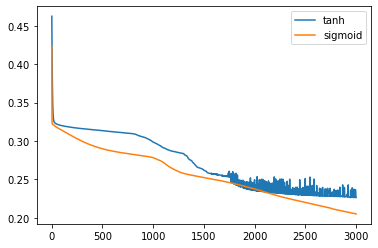

In [59]:
x = list(range(1, 3001))

plt.plot(x, err_tanh, label='tanh')
plt.plot(x, err_sigmoid, label='sigmoid')

plt.legend(loc='upper right')
plt.show()

In [60]:
end = time.time()
print(end - start) # sekundy

7185.17418217659


In [61]:
print((end-start)/3600) # godziny

1.995881717271275
